# Imports

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import glob
from model import CNN_Classifier_Lightning
import pytorch_lightning as pl
import torch
from torch.utils.data import TensorDataset, DataLoader


# Scratchwork

This is a scratchwork file for testing out data extraction on .emsa sprectra data files.

In [ ]:
def read_emsa_spectrum(filepath: str, header_lines: int = 31) -> np.ndarray:
    """
    Reads a .emsa file and extracts the numerical data spectrum.

    Args:
        filepath (str): The full path to the .emsa file.
        header_lines (int): The number of header lines to skip.

    Returns:
        np.ndarray: A 1D NumPy array containing the spectrum data.
    """
    try:
        spectrum = np.loadtxt(filepath, skiprows=header_lines)
        return spectrum
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return np.array([]) # Return an empty array on error
    except ValueError:
        print(f"Error: Could not convert data to numbers after the header.")
        print("Please check the file to ensure all lines after the header are numeric.")
        return np.array([])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return np.array([])
    
def spectrums_from_directory(directory):
    emsa_files = sorted(glob.glob(os.path.join(directory, '*.emsa')))
    if emsa_files:
        list_of_spectra = [read_emsa_spectrum(f) for f in emsa_files]
        spectra_array = np.array([s for s in list_of_spectra if s.size > 0])
        
        if spectra_array.size == 0:
            print("Could not read any valid spectra from the files found.")
        
        return spectra_array
    else:
        print(f"No .emsa files found in the directory: {directory}")


In [ ]:
sp = read_emsa_spectrum(r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb\spectrum.emsa")
print(sp.shape)
print(sp)
plt.plot(sp)

In [ ]:
sps = spectrums_from_directory(r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb")
sps.shape

In [ ]:
random_indices = np.random.randint(0, 19, size=(4, 256, 256))
spectral_volume = sps[random_indices]
spectral_volume.shape

In [2]:
from data import generate_training_data

training_HSI, training_classes = generate_training_data(
    image_directory = r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Images\Two-tone\Training",
    target_size = (256, 256),
    spectrum_directories = [
        r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Sn",
        r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb"
    ],
    spectrum_range = (0, 9)
)

val_HSI, val_classes = generate_training_data(
    image_directory = r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Images\Two-tone\Validation",
    target_size = (256, 256),
    spectrum_directories = [
        r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Sn",
        r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb"
    ],
    spectrum_range = (10, 19)
)

Scanning directory: D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Images\Two-tone\Training
Looking for files with extensions: ('.jpg', '.jpeg', '.png')
All images will be resized to: (256, 256)

Successfully compiled 2 images.
Masking over data for class 0...
Masking over data for class 1...
Scanning directory: D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Images\Two-tone\Validation
Looking for files with extensions: ('.jpg', '.jpeg', '.png')
All images will be resized to: (256, 256)

Successfully compiled 2 images.
Masking over data for class 0...
Masking over data for class 1...


In [3]:
np.save(r"data\training_HSI", training_HSI)
np.save(r"data\training_classes", training_classes)
np.save(r"data\validation_HSI", val_HSI)
np.save(r"data\validation_classes", val_classes)

# Train CNN

In [17]:
training_HSI = np.load("data\\training_HSI.npy")
training_classes = np.load("data\\training_classes.npy")
val_HSI = np.load(r"data\validation_HSI.npy")
val_classes = np.load(r"data\validation_classes.npy")

In [18]:
HSI_training_tensor = torch.Tensor(training_HSI.reshape((-1, 1, training_HSI.shape[-1])))
classes_training_tensor = torch.Tensor(training_classes.reshape((-1, 1)))

HSI_val_tensor = torch.Tensor(val_HSI.reshape((-1, 1, val_HSI.shape[-1])))
classes_val_tensor = torch.Tensor(val_classes.reshape((-1, 1)))

In [19]:
model = CNN_Classifier_Lightning(input_shape=(HSI.shape[-1],), num_classes=2)

trainer = pl.Trainer(
    accelerator = "auto",
    #precision   = '16-mixed',
    devices     = 1,
    max_epochs  = 10,
    #gradient_clip_val=0.5,
    logger      = pl.loggers.TensorBoardLogger("lightning_logs/", name="CNN")
)

training_dataset = TensorDataset(HSI_training_tensor, classes_training_tensor)
val_dataset = TensorDataset(HSI_val_tensor, classes_val_tensor)

train_loader = DataLoader(training_dataset, batch_size=8192)
val_loader   = DataLoader(val_dataset, batch_size=8192)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | CNN_Classifier | 4.0 K  | train
-------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 29.69it/s]

c:\Users\nolan\OneDrive\Desktop\College\Research\ANL\SLADS\SLADS-Net\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\nolan\OneDrive\Desktop\College\Research\ANL\SLADS\SLADS-Net\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\nolan\OneDrive\Desktop\College\Research\ANL\SLADS\SLADS-Net\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s, v_num=22, train_loss=0.00555, val_loss=0.00588]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  5.53it/s, v_num=22, train_loss=0.00555, val_loss=0.00588]


In [26]:
classification = torch.softmax(
                    model(torch.tensor(val_HSI[1]).float().reshape(-1, 1, 2048))
                        .reshape(256,256,2), 2).detach().numpy()

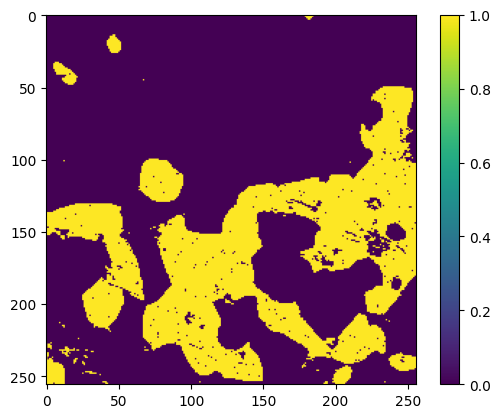

In [27]:
plt.imshow(np.argmax(classification[:,:], axis=2))
plt.colorbar()
plt.show()

In [29]:
torch.save(model.model.state_dict(), "pretrained_models\\CNN.pt")